# Setup

In [1]:
import sys
import os
import importlib

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib.lines import Line2D
import proplot as pplt

def ancestor_folder_path(current_path, ancestor_folder_name):  
    parent_path = os.path.dirname(current_path)
    if parent_path == current_path:
        raise ValueError("Couldn't find ancestor folder.")
    if parent_path.split('/')[-1] == ancestor_folder_name:
        return parent_path
    return ancestor_folder_path(parent_path, ancestor_folder_name)

sys.path.append(ancestor_folder_path(os.getcwd(), 'scdist'))
from tools import animation as myanim
from tools import ap_utils
from tools import beam_analysis as ba
from tools import plotting as myplt
from tools import plot_utils
from tools import utils
from tools.plotting import set_labels

Plot settings

In [2]:
# Plotting
pplt.rc['figure.facecolor'] = 'white' 
pplt.rc['grid.alpha'] = 0.04
pplt.rc['axes.grid'] = False
pplt.rc['savefig.dpi'] = 'figure'
pplt.rc['animation.html'] = 'jshtml' 

plt_kws = dict(
    lw=1, 
    marker='.',
    markersize=3,
    legend=False,
)

format_kws = dict(
    xgrid=False,
    ygrid=True,
)

def savefig(filename, folder, suffix='.png', **kws):
    kws.setdefault('dpi', 300)
    kws.setdefault('facecolor', 'white')
    filename = ''.join([filename, suffix])
    plt.savefig(os.path.join(folder, filename), **kws)

# Animation
animate = True
animate_kws = dict(skip=4, interval=1000./3.)

In [3]:
width, height = 3.5, 2.5

def setup_figure(opt=1):
    """Convenience function to create subplots."""
    if opt == 1:
        nrows, ncols, figsize = 1, 1, (width, height)
    elif opt == 2:
        nrows, ncols, figsize = 3, 1, (width, 2*height)
    elif opt == 3:
        nrows, ncols, figsize = 3, 2, (1.6*width, 2*height)
    elif opt == 4:
        nrows, ncols, figsize = 1, 2, (7, 2.5)
    fig, axes = pplt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, spany=False, aligny=True)
    axes.format(xlabel='Turn number')
    return fig, axes

Input/output file locations.

In [4]:
# Input file locations
filenames = {
    'env_params': '_output/data/envelope/env_params.dat',
    'testbunch_coords': '_output/data/envelope/testbunch_coords.npy',
    'bunch_coords': '_output/data/bunch/bunch_coords.npy',
    'bunch_moments': '_output/data/bunch/bunch_moments.dat',
    'transfer_matrix': '_output/data/transfer_matrix.dat'
}
files_exist = {key: utils.file_exists(filename) for key, filename in filenames.items()}

# Output file locations
dirs = {
    'env': './_output/figures/envelope/',
    'bunch': './_output/figures/bunch/',
    'comparison': './_output/figures/comparison/'
}

# Envelope

In [5]:
mode = int(np.loadtxt('_output/data/mode.txt'))
env_params = np.loadtxt(filenames['env_params'])
env_params *= 1000. # [convert to mm mrad]
env_stats = ba.BeamStats(mode=mode)
env_stats.read_env(env_params)

## Twiss parameters 

### 2D Twiss

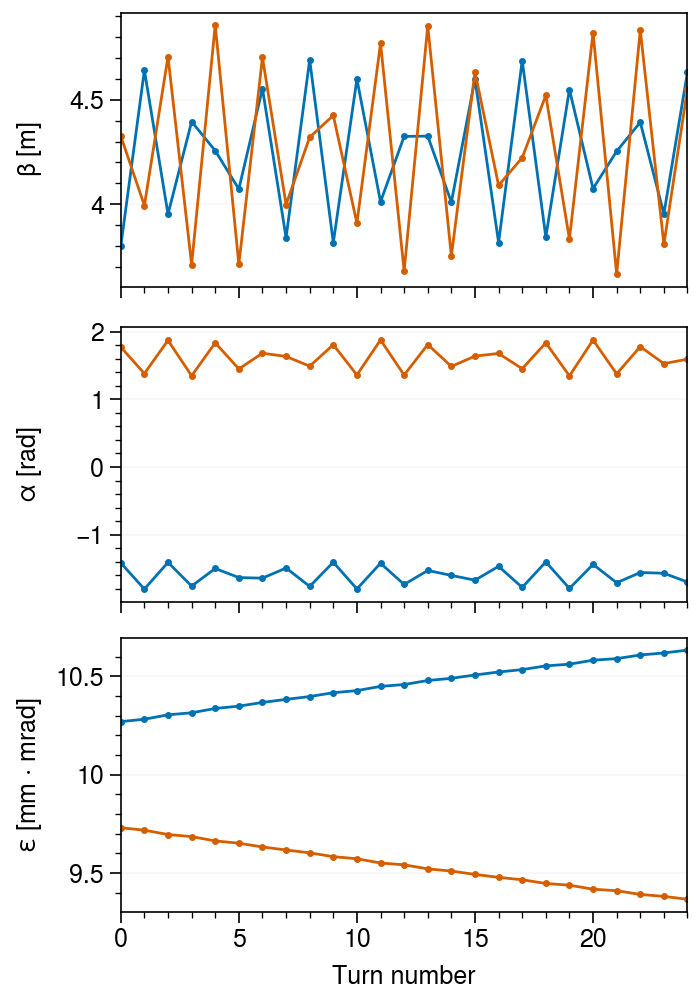

In [6]:
fig, axes = setup_figure(2);
columns = (['beta_x','beta_y'], ['alpha_x','alpha_y'], ['eps_x','eps_y'])
ylabels = (r'$\beta$ [m]', r'$\alpha$ [rad]', r'$\varepsilon$ [mm $\cdot$ mrad]')
for ax, col in zip(axes, columns):
    env_stats.twiss2D[col].plot(ax=ax, **plt_kws)
set_labels(axes, ylabels, 'ylabel')
axes.format(**format_kws)
savefig('twiss2D', dirs['env'])

### 4D Twiss 

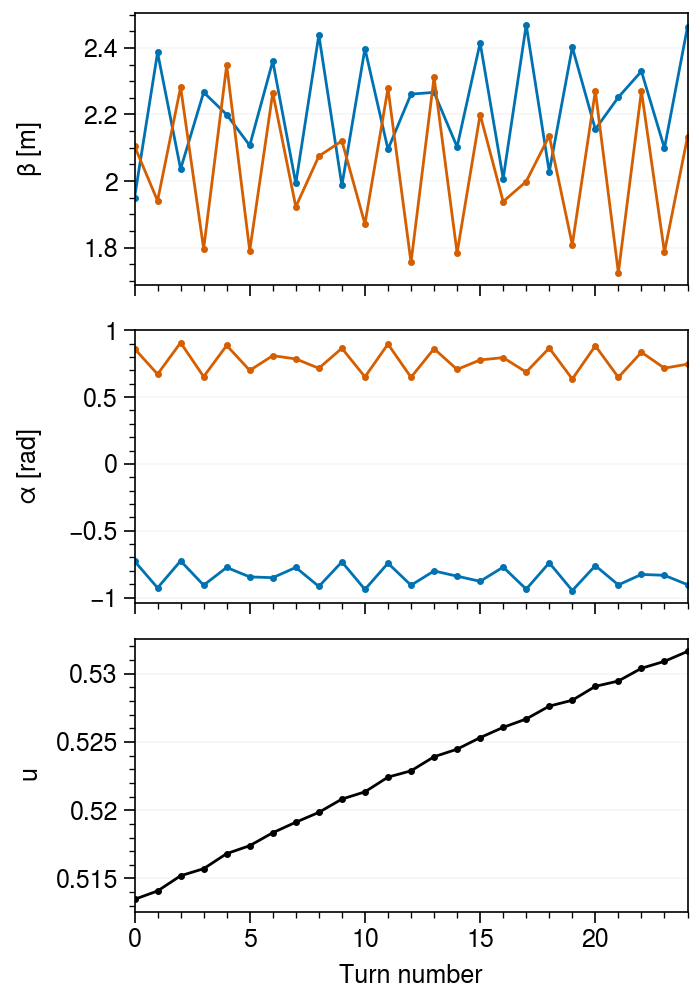

In [7]:
fig, axes = setup_figure(2)
env_stats.twiss4D[['beta_x','beta_y']].plot(ax=axes[0], **plt_kws)
env_stats.twiss4D[['alpha_x','alpha_y']].plot(ax=axes[1], **plt_kws)
env_stats.twiss4D[['u']].plot(ax=axes[2], color='k', **plt_kws)
axes[0].set_ylabel(r'$\beta$ [m]')
axes[1].set_ylabel(r'$\alpha$ [rad]')
axes[2].set_ylabel(r'$u$')
axes.format(**format_kws)
savefig('twiss4D', dirs['env'])

### Phase difference (nu)

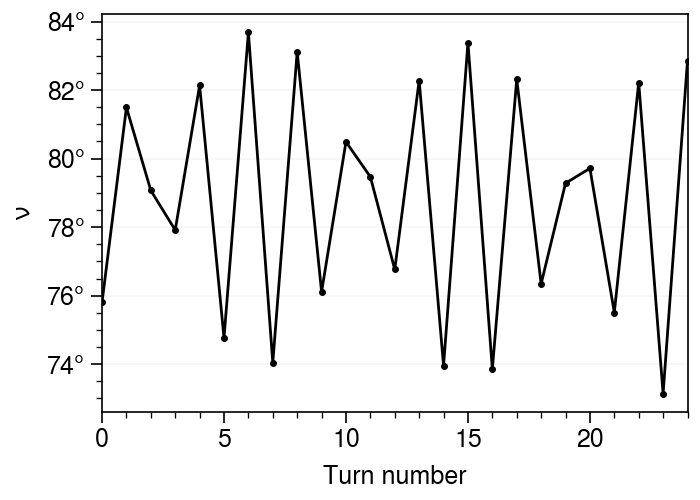

In [8]:
fig, ax = setup_figure(1)
env_stats.twiss4D['nu'].plot(color='k', ax=ax, **plt_kws)
ax.format(ylabel=r'$\nu$', yformatter='deg', **format_kws)
savefig('twiss4D-nu', dirs['env'])

### Emittance 

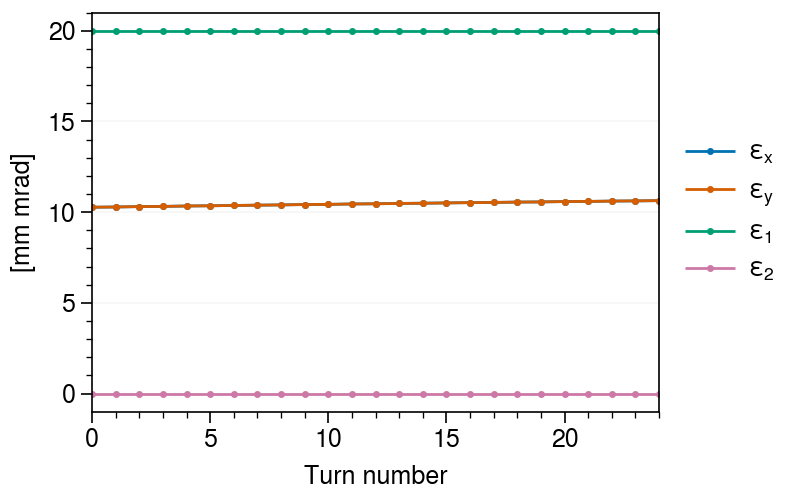

In [9]:
fig, ax = pplt.subplots(figsize=(4.0, 2.5))
g1 = ax.plot(env_stats.twiss2D['eps_x'], **plt_kws)
g2 = ax.plot(env_stats.twiss2D['eps_x'], **plt_kws)
g3 = ax.plot(env_stats.twiss4D['eps_1'], **plt_kws)
g4 = ax.plot(env_stats.twiss4D['eps_2'], **plt_kws)
ax.format(ylabel='[mm mrad]', xlabel='Turn number', **format_kws)
ax.legend([g1, g2, g3, g4],
          labels=[r'$\varepsilon_x$', r'$\varepsilon_y$', 
                  r'$\varepsilon_1$', r'$\varepsilon_2$'], 
          ncols=1, loc='r', framealpha=0.)
savefig('emittances', dirs['env'])

## Moments 

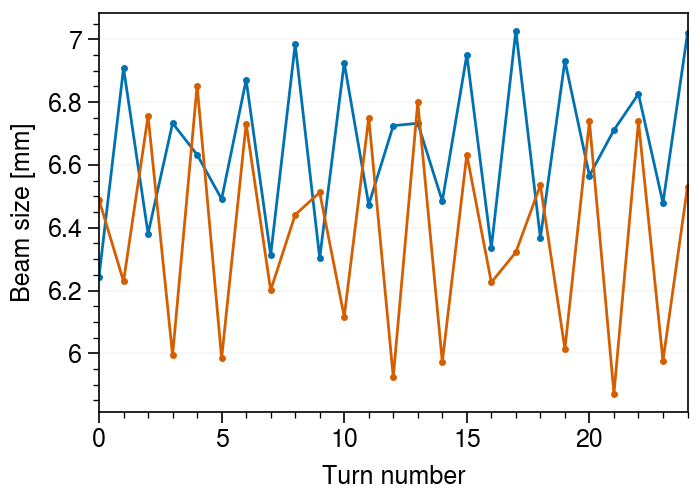

In [10]:
fig, ax = setup_figure(1)
env_stats.moments[['x_rms','y_rms']].plot(ax=ax, **plt_kws)
ax.format(ylabel='Beam size [mm]', **format_kws)
savefig('beamsize', dirs['env'])

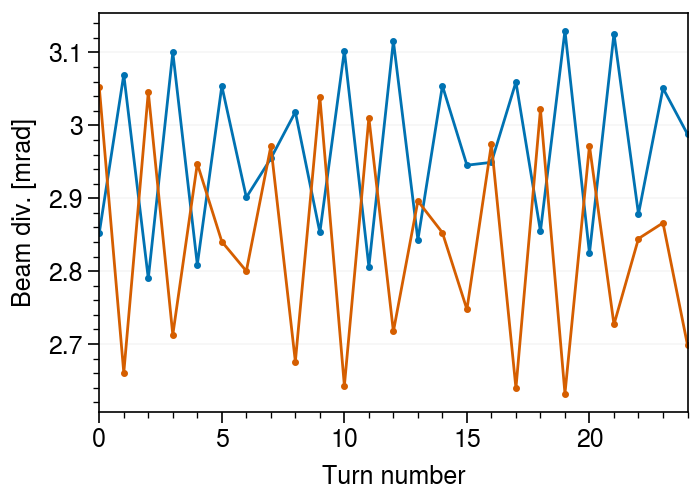

In [11]:
fig, ax = setup_figure(1)
env_stats.moments[['xp_rms','yp_rms']].plot(ax=ax, **plt_kws)
ax.format(ylabel='Beam div. [mrad]', **format_kws)
savefig('beamdiv', dirs['env'])

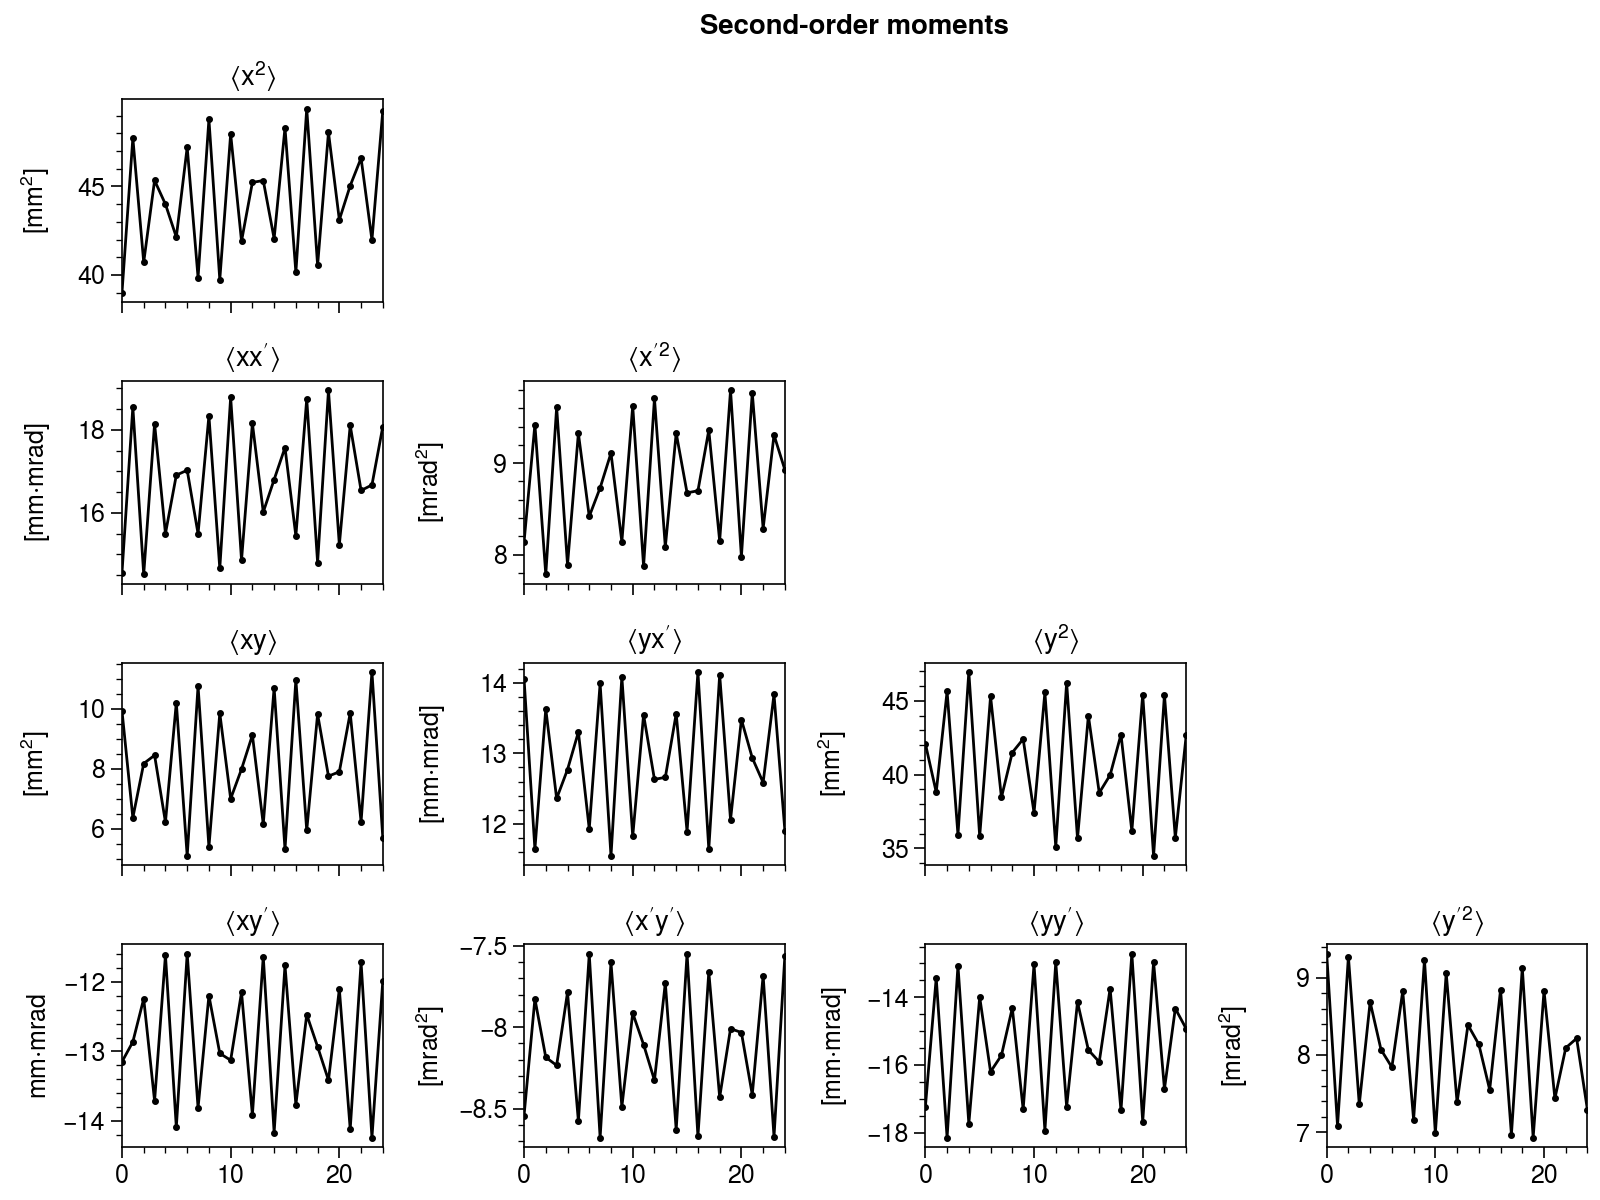

In [12]:
fig, axes = pplt.subplots(nrows=4, ncols=4, sharey=False, figsize=(8, 6), 
                          spany=False, aligny=True)
myplt.make_lower_triangular(axes)
axes.format(suptitle='Second-order moments', titleborder=True, **format_kws)
for i in range(4):
    for j in range(i + 1):
        ax = axes[i, j]
        col = plot_utils.moment_label(i, j)
        env_stats.moments[col].plot(ax=ax, color='k', **plt_kws)
        ax.format(title=plot_utils.moment_label_string(i, j))
set_labels(axes[0:, 0], [r'[mm$^2$]', r'[mm$\cdot$mrad]', r'[mm$^2$]', r'mm$\cdot$mrad'], 'ylabel')
set_labels(axes[1:, 1], [r'[mrad$^2$]', r'[mm$\cdot$mrad]', r'[mrad$^2$]'], 'ylabel')
set_labels(axes[2:, 2], [r'[mm$^2$]', r'[mm$\cdot$mrad]'], 'ylabel')
set_labels(axes[3:, 3], [r'[mrad$^2$]'], 'ylabel')
savefig('all_moments', dirs['env'])

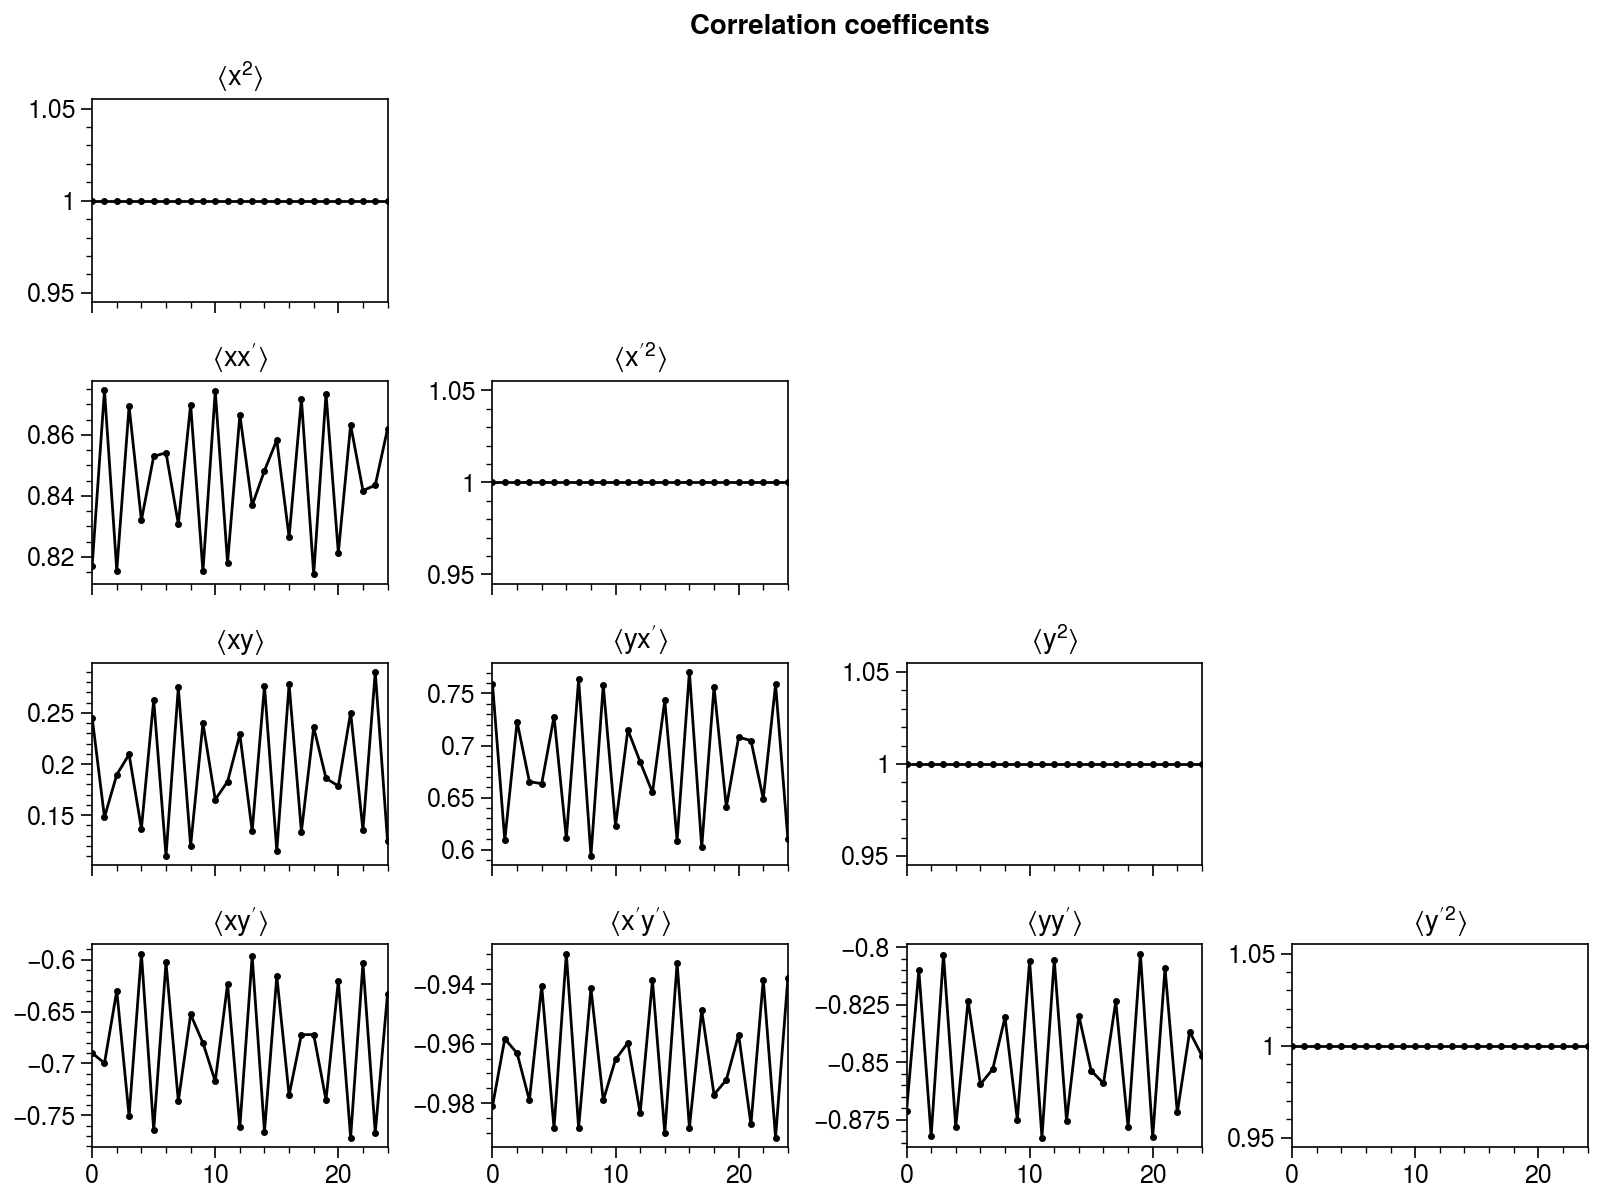

In [13]:
fig, axes = pplt.subplots(nrows=4, ncols=4, sharey=False, figsize=(8, 6), 
                          spany=False, aligny=True)
myplt.make_lower_triangular(axes)
axes.format(suptitle='Correlation coefficents', titleborder=True, **format_kws)
for i in range(4):
    for j in range(i + 1):
        ax = axes[i, j]
        col = plot_utils.moment_label(i, j)
        env_stats.corr[col].plot(ax=ax, color='k', **plt_kws)
        ax.format(title=plot_utils.moment_label_string(i, j))
savefig('all_correlations', dirs['env'])

## Real space orientation

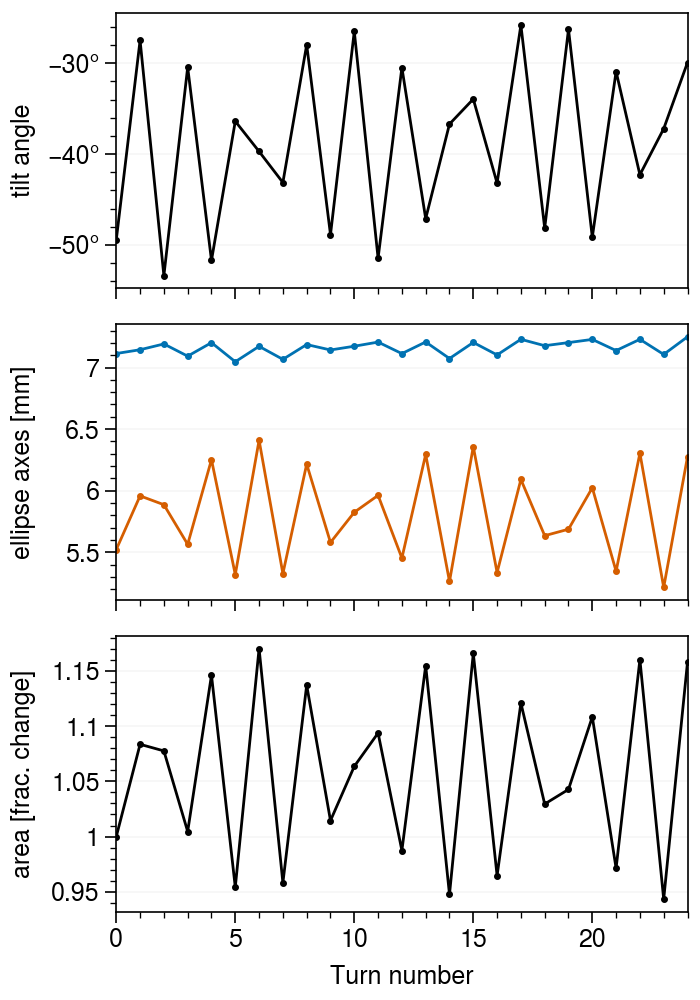

In [14]:
fig, axes = setup_figure(2)
env_stats.realspace[['angle']].plot(ax=axes[0], color='k', **plt_kws)
env_stats.realspace[['cx','cy']].plot(ax=axes[1], **plt_kws)
env_stats.realspace[['area_rel']].plot(ax=axes[2], color='k', **plt_kws)
set_labels(axes, ['tilt angle', 'ellipse axes [mm]', 'area [frac. change]'], 'ylabel')
axes.format(**format_kws)
axes[0].format(yformatter='deg')
savefig('beam_dims', dirs['env'])

## Tunes 

The tunes are computed for a particle on the beam envelope (the tune of every particle is the same).

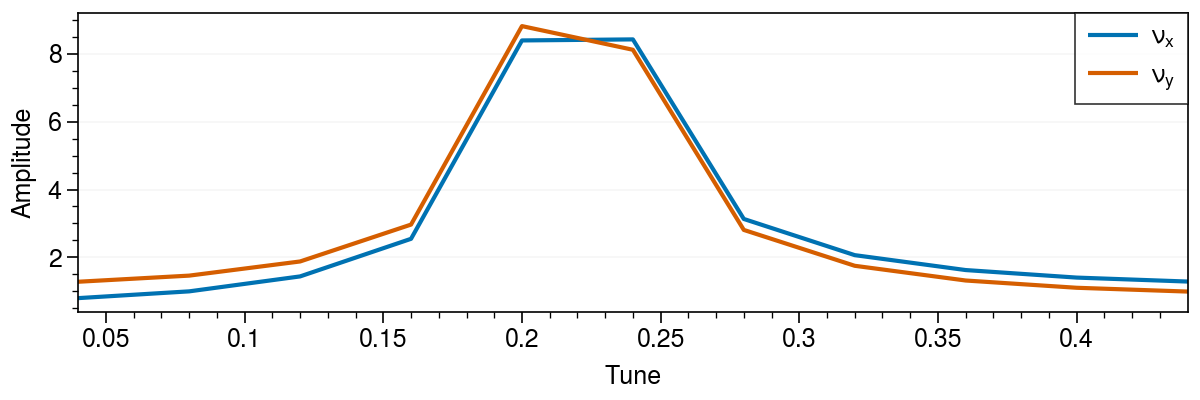

In [15]:
env_coords = np.array([ba.get_ellipse_coords(p) for p in env_params])
fig, ax = pplt.subplots(figsize=(6, 2))
myplt.fft(ax, env_coords[:, 0, 0], env_coords[:, 0, 2])
ax.legend(ncols=1)
ax.format(**format_kws)
savefig('fft', dirs['env']);

## Phase space projections 

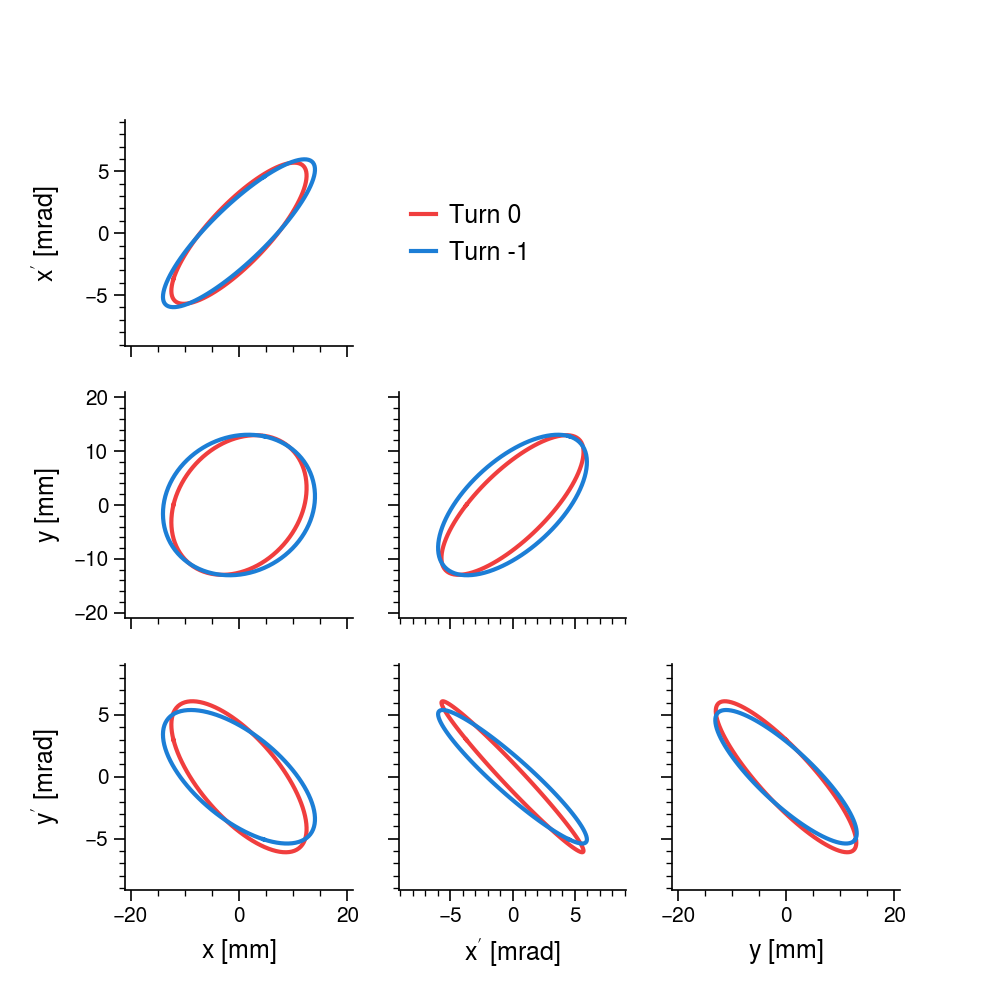

In [16]:
turns = [0, -1]
axes = myplt.corner_env(
    env_params[turns],
    figsize=(5, 5),
    limits=None,
    pad=0.5,
    cmap=('red7', 'blue7'),
    constrained_layout=False,
)
axes[1, 1].legend(['Turn {}'.format(t) for t in turns], loc=(0., 1.5), handlelength=1., framealpha=0.)
savefig('env_init_final', dirs['env'])

In [17]:
if animate:
    anim = myanim.corner_env(
        env_params,
        figsize=(5, 5),
        limits=None,
        dims='all',
        pad=0.5,
        show_init=True, 
        lw=0,
        text_fmt='Turn = {}',
        **animate_kws
    )
    utils.play(anim)

## Transfer matrix 

In [18]:
if files_exist['transfer_matrix']:
    M = np.loadtxt(filenames['transfer_matrix'])
    M_eigvals, M_eigvecs = np.linalg.eig(M)
    M_eigtunes = np.degrees(np.arccos(M_eigvals.real))
    print('M =')
    print(M)
    print()
    print('Eigenvalues:')
    print(M_eigvals[[0, 2]])
    print()
    print('Phase advances [deg]:')
    print(M_eigtunes[[0, 2]])
    print()
    print('Tunes:')
    print(M_eigtunes[[0, 2]] / 360.)

M =
[[-1.36859008e+00  4.14463088e+00  2.93826527e-03  6.58258822e-03]
 [-8.20682121e-01  1.75467003e+00  1.60084628e-03  3.43134048e-03]
 [-3.26508788e-04  1.43981061e-03  1.75716701e+00  4.14665044e+00]
 [ 2.78115510e-04  1.68723293e-04 -8.21466306e-01 -1.36943907e+00]]

Eigenvalues:
[0.19251347+0.98129433j 0.19439047+0.98092423j]

Phase advances [deg]:
[78.90049596 78.79088102]

Tunes:
[0.21916804 0.21886356]


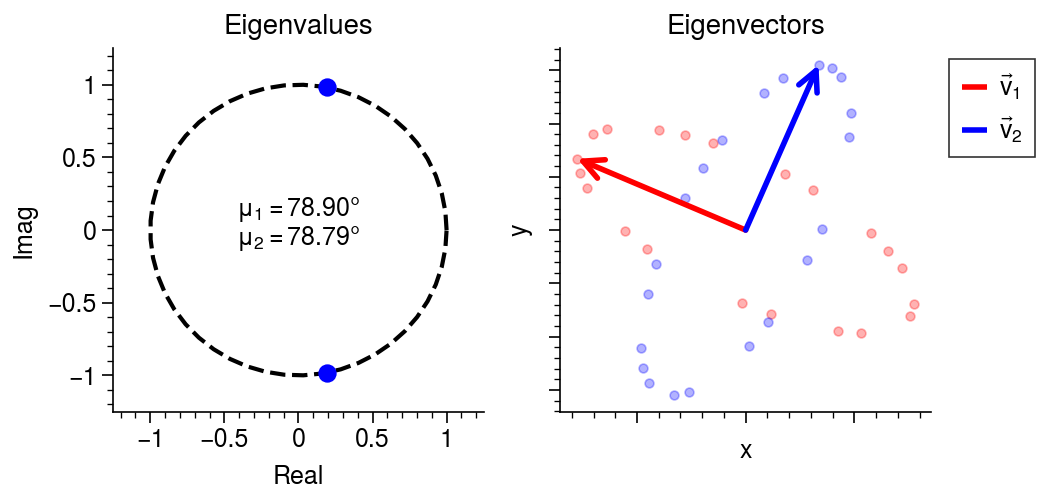

In [19]:
if files_exist['transfer_matrix']:
    
    colors = ['red', 'blue']
    
    fig, axes = pplt.subplots(ncols=2, figsize=(5.25, 2.5), 
                              share=False, span=False)
    axes.format(grid=False)
    myplt.despine(axes)
    ax1, ax2 = axes

    # Plot eigenvalues in complex plane
    psi = np.linspace(0, 2*np.pi, 50)
    x_circ, y_circ = np.cos(psi), np.sin(psi)
    ax1.plot(x_circ, y_circ, 'k--', zorder=0)
    for e, c in zip(M_eigvals, colors):
        ax1.scatter(e.real, e.imag, color=colors[i % 2])
    scale = 1.25
    ax1.format(
        xticks=[-1, -0.5, 0, 0.5, 1], yticks=[-1, -0.5, 0, 0.5, 1], 
        ylim=(-scale, scale), xlim=(-scale, scale),
        xlabel='Real', ylabel='Imag', title='Eigenvalues')
    ax1.annotate(r'$\mu_1 = {:.2f}\degree$'.format(M_eigtunes[0]), xy=(0, +0.1), horizontalalignment='center')
    ax1.annotate(r'$\mu_2 = {:.2f}\degree$'.format(M_eigtunes[2]), xy=(0, -0.1), horizontalalignment='center')

    # Plot turn-by-turn trajectory of eigenvectors.
    myplt.eigvec_trajectory(ax2, M, 'x', 'y', s=10)
    ax2.format(xticklabels=[], yticklabels=[], 
               ylabel='y', xlabel='x', title='Eigenvectors')

    # Add legend.
    lines = [Line2D([0], [0], color=c, lw=2) for c in colors]
    ax2.legend(lines, labels=[r'$\vec{v}_1$', r'$\vec{v}_2$'],
               loc=(1.05, 0.7), handlelength=1, ncols=1);

    savefig('eigvecs_realspace', dirs['env'])

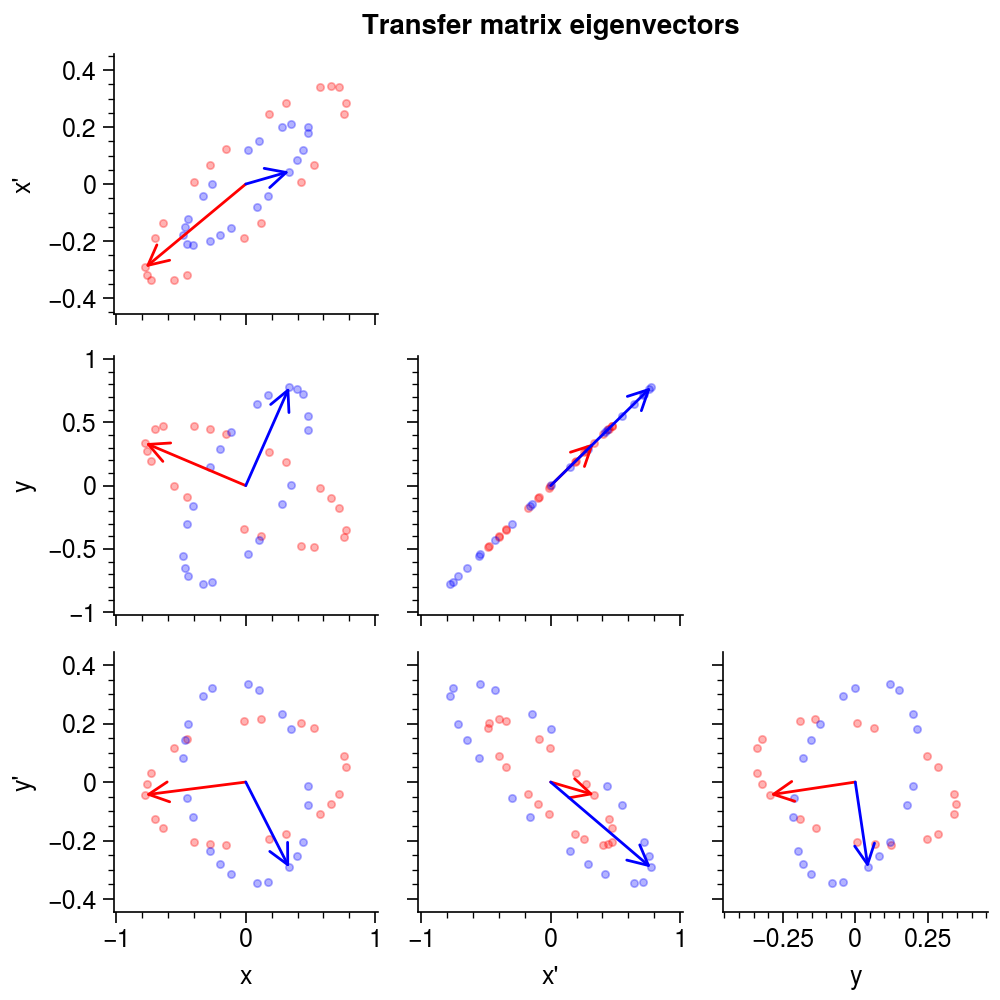

In [20]:
if files_exist['transfer_matrix']:
    
    # Set up figure
    fig, axes = pplt.subplots(nrows=3, ncols=3, figsize=(5, 5), span=False)
    axes.format(grid=False, suptitle='Transfer matrix eigenvectors')
    myplt.make_lower_triangular(axes)
    myplt.despine(axes)
    labels = ["x", "x'", "y", "y'"]
    set_labels(axes[-1, :], labels[:-1], 'xlabel')
    set_labels(axes[:, 0], labels[1:], 'ylabel')

    # Plot eigenvectors and their trajectories.
    for i in range(3):
        for j in range(3):
            if i >= j:
                ax = axes[i, j]
                yvar = ['xp', 'y', 'yp'][i]
                xvar = ['x', 'y', 'xp'][j]
                myplt.eigvec_trajectory(ax, M, xvar, yvar, s=7, lw=1)

    # Zoom out a bit.
    for i in range(3):
        ymin, ymax = axes[i, 0].get_ylim()
        xmin, xmax = axes[-1, i].get_xlim()
        scale = 1.2
        axes[i, :].format(ylim=(-scale*ymax, scale*ymax))
        axes[:, i].format(xlim=(-scale*xmax, scale*xmax))

    savefig('eigvecs', dirs['env'])

## Test bunch

The linear space charge kicks for the test bunch are calculated directly from the envelope parameters.

In [21]:
if files_exist['testbunch_coords']:
    test_coords = np.load(files['testbunch_coords'])
    nframes, ntestparts, ndims = test_coords.shape
    print('Test bunch coordinates:')
    print('nparts, nframes = {}, {}'.format(ntestparts, nframes))

# Bunch

In [34]:
if files_exist['bunch_coords']:
    coords = np.load(filenames['bunch_coords'])  
    coords[:, :, :4] *= 1000. # convert to [mm mrad]
    n_frames, n_parts, n_dims = coords.shape
    print('Bunch coordinates:')
    print('n_frames, n_parts = {}, {}'.format(n_frames, n_parts))
        
if files_exist['bunch_moments']:
    moments = np.loadtxt(filenames['bunch_moments'])
    bunch_stats = ba.BeamStats(mode)
    bunch_stats.read_moments(moments)

Bunch coordinates:
n_frames, n_parts = 25, 100000


## Twiss parameters 

### 2D Twiss

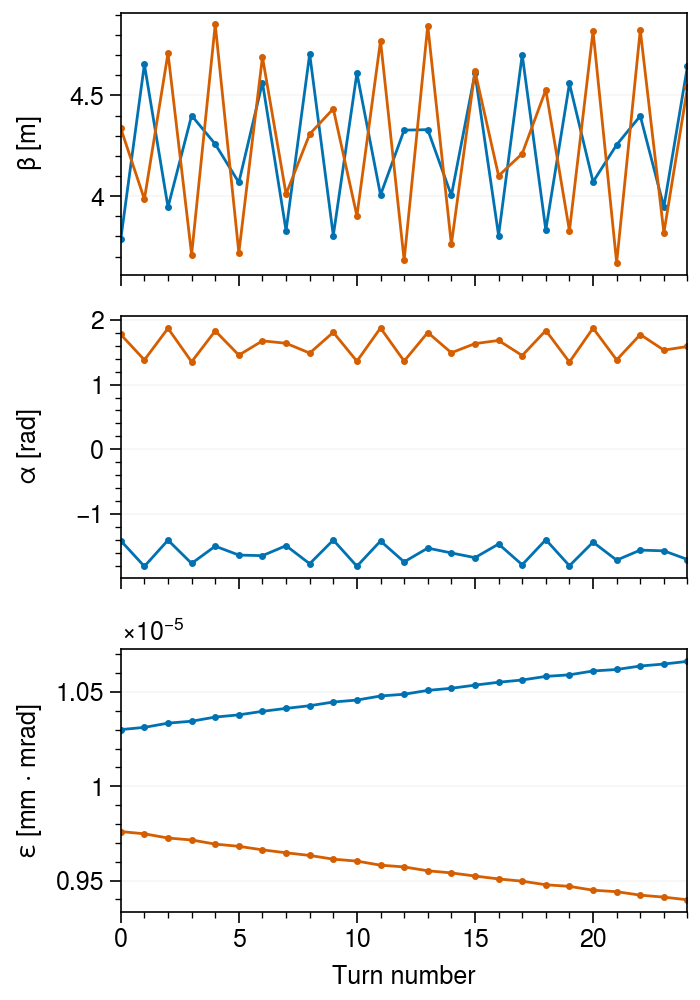

In [35]:
if files_exist['bunch_moments']:
    fig, axes = setup_figure(2);
    columns = (['beta_x','beta_y'], ['alpha_x','alpha_y'], ['eps_x','eps_y'])
    ylabels = (r'$\beta$ [m]', r'$\alpha$ [rad]', r'$\varepsilon$ [mm $\cdot$ mrad]')
    for ax, col in zip(axes, columns):
        bunch_stats.twiss2D[col].plot(ax=ax, **plt_kws)
    set_labels(axes, ylabels, 'ylabel')
    axes.format(**format_kws)
    savefig('twiss2D', dirs['bunch'])

### Emittance 

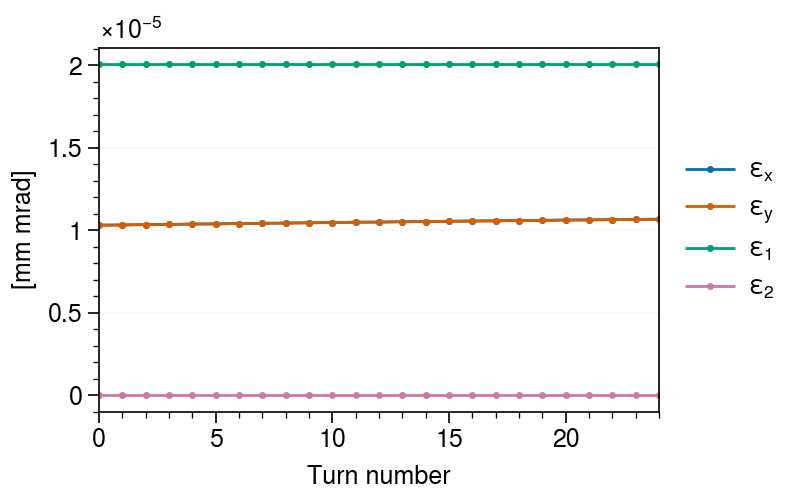

In [31]:
if files_exist['bunch_moments']:
    fig, ax = pplt.subplots(figsize=(4.0, 2.5))
    g1 = ax.plot(bunch_stats.twiss2D['eps_x'], **plt_kws)
    g2 = ax.plot(bunch_stats.twiss2D['eps_x'], **plt_kws)
    g3 = ax.plot(bunch_stats.twiss4D['eps_1'], **plt_kws)
    g4 = ax.plot(bunch_stats.twiss4D['eps_2'], **plt_kws)
    ax.format(ylabel='[mm mrad]', xlabel='Turn number', **format_kws)
    ax.legend([g1, g2, g3, g4],
              labels=[r'$\varepsilon_x$', r'$\varepsilon_y$', 
                      r'$\varepsilon_1$', r'$\varepsilon_2$'], 
              ncols=1, loc='r', framealpha=0.)
    savefig('emittances', dirs['bunch'])

## Moments 

In [ ]:
if files_exist['bunch_moments']:
    fig, ax = setup_figure(1)
    bunch_stats.moments[['x_rms','y_rms']].plot(ax=ax, **plt_kws)
    ax.format(xlabel='Turn number', ylabel='Beam size [mm]')
    save('beamsize', dirs['bunch'], dpi=dpi)

In [ ]:
if files_exist['bunch_moments']:
    fig, ax = setup_figure(1)
    bunch_stats.moments[['xp_rms','yp_rms']].plot(ax=ax, **plt_kws)
    ax.format(xlabel='Turn number', ylabel='Beam div. [mrad]')
    save('beamdiv', dirs['bunch'], dpi=dpi)

In [ ]:
if files_exist['bunch_moments']:
    fig, axes = plot.subplots(nrows=4, ncols=4, sharey=False, figsize=(8, 6), 
                          spany=False, aligny=True)
    myplt.make_lower_triangular(axes)
    axes.format(xlabel='Turn number', suptitle='Transverse moments', titleborder=True)
    for i in range(4):
        for j in range(i + 1):
            ax = axes[i, j]
            col = moment_label(i, j)
            bunch_stats.moments[col].plot(ax=ax, color='k', **plt_kws)
            ax.format(title=moment_label_string(i, j))
    set_labels(axes[0:, 0], [r'[mm$^2$]', r'[mm$\cdot$mrad]', r'[mm$^2$]', r'mm$\cdot$mrad'], 'ylabel')
    set_labels(axes[1:, 1], [r'[mrad$^2$]', r'[mm$\cdot$mrad]', r'[mrad$^2$]'], 'ylabel')
    set_labels(axes[2:, 2], [r'[mm$^2$]', r'[mm$\cdot$mrad]'], 'ylabel')
    set_labels(axes[3:, 3], [r'[mrad$^2$]'], 'ylabel')
    save('all_moments', dirs['env'], dpi=dpi)

In [ ]:
if files_exist['bunch_moments']:
    fig, axes = plot.subplots(nrows=4, ncols=4, sharey=False, figsize=(8, 6), 
                          spany=False, aligny=True)
    myplt.make_lower_triangular(axes)
    axes.format(xlabel='Turn number', suptitle='Transverse moments', titleborder=True)
    for i in range(4):
        for j in range(i + 1):
            ax = axes[i, j]
            col = moment_label(i, j)
            bunch_stats.corr[col].plot(ax=ax, color='k', **plt_kws)
            ax.format(title=moment_label_string(i, j))
    save('all_correlations', dirs['env'], dpi=dpi)

## Beam orientation

In [ ]:
if files_exist['bunch_moments']:
    fig, axes = setup_figure(2)
    bunch_stats.realspace[['angle']].plot(ax=axes[0], **plt_kws)
    bunch_stats.realspace[['cx','cy']].plot(ax=axes[1], **plt_kws)
    bunch_stats.realspace[['area_rel']].plot(ax=axes[2], color='k', **plt_kws)
    set_labels(axes, ['tilt angle', 'ellipse axes [mm]', 'area [frac. change]'], 'ylabel')
    ax.format(xlabel='Turn number')
    axes[0].format(yformatter='deg')
    save('beam_dims', dirs['bunch'], dpi=dpi)

## Phase space projections 

In [ ]:
if files_exist['bunch_coords']:
    for i, name in zip((1, -1), ('Initial', 'Final')):
        axes = myplt.corner(coords[i], text=name, figsize=5.5)
        save(name, dirs['bunch'], dpi=dpi)

In [ ]:
if files_exist['bunch_coords'] and animate:
    anim = myanim.corner(coords[t0:t1], skip=skip, diag_kind='hist', fps=fps, 
                         text_fmt='Turn = {}', figsize=6)
    play(anim)

# Comparison 
Compare the theory (envelope calculation) to the PIC simulation.

In [ ]:
if files_exist['bunch_moments']:
    plt_kws_env = dict(
        lw=None,
        marker=None,
        markersize=None,
        color='black',
        legend=False,
    )
    plt_kws_bunch = dict(
        lw=0,
        marker='.',
        markersize=None,
        color='red',
        legend=False,
    )
    dataframes = [env_stats, bunch_stats]
    kws_list = [plt_kws_env, plt_kws_bunch]

## Moments

In [ ]:
if files_exist['bunch_moments']:
    fig, axes = setup_figure(4)
    for ax, key in zip(axes, ('x_rms', 'y_rms')):
        for df, kws in zip(dataframes, kws_list):
            df.moments[key].plot(ax=ax, **kws)
    axes.format(xlabel='Turn number', ylabel='[mm]')
    set_labels(axes, [r'$\sqrt{\langle{x^2}\rangle}$', r'$\sqrt{\langle{y^2}\rangle}$'], 'title')
    axes[1].legend(labels=['theory', 'calc'], ncols=1, loc=(1.02, 0), fontsize='small')
    save('beamsize', dirs['comparison'], dpi=dpi)

In [ ]:
if files_exist['bunch_moments']:
    fig, axes = setup_figure(4)
    for ax, key in zip(axes, ('xp_rms', 'yp_rms')):
        for df, kws in zip(dataframes, kws_list):
            df.moments[key].plot(ax=ax, **kws)
    axes.format(xlabel='Turn number', ylabel='[mrad]')
    set_labels(axes, [r"$\sqrt{\langle{x'^2}\rangle}$", r"$\sqrt{\langle{y'^2}\rangle}$"], 'title')
    axes[1].legend(labels=['theory', 'calc'], ncols=1, loc=(1.02, 0), fontsize='small')
    save('up', dirs['comparison'], dpi=dpi)

In [ ]:
if files_exist['bunch_moments']:
    fig, ax = plot.subplots(figsize=(1.25*width, height))
    for df, kws in zip(dataframes, kws_list):
        df.corr['xy'].plot(ax=ax, **kws)
    ax.format(title=r"$x$-$y$ corr. coef.", xlabel='Turn number')
    ax.legend(labels=['theory', 'calc'], ncols=1, loc=(1.02, 0), fontsize='small')
    save('xy_corr', dirs['comparison'], dpi=dpi)

In [ ]:
if files_exist['bunch_moments']:
    fig, axes = plot.subplots(nrows=4, ncols=4, sharey=False, figsize=(8, 6), spany=False, aligny=True)
    myplt.make_lower_triangular(axes)
    for i in range(4):
        for j in range(i + 1):
            ax = axes[i, j]
            ax.format(title=moment_label_string(i, j))
            col = moment_label(i, j)
            for df, kws in zip(dataframes, kws_list):
                df.moments[col].plot(ax=ax, **kws)
    set_labels(axes[0:, 0], [r'[mm$^2$]', r'[mm$\cdot$mrad]', r'[mm$^2$]', r'mm$\cdot$mrad'], 'ylabel')
    set_labels(axes[1:, 1], [r'[mrad$^2$]', r'[mm$\cdot$mrad]', r'[mrad$^2$]'], 'ylabel')
    set_labels(axes[2:, 2], [r'[mm$^2$]', r'[mm$\cdot$mrad]'], 'ylabel')
    set_labels(axes[3:, 3], [r'[mrad$^2$]'], 'ylabel')
    custom_lines = [Line2D([0], [0], color=plt_kws_env['color']),
                    Line2D([0], [0], color=plt_kws_bunch['color'])]
    axes[0, 1].legend(custom_lines, ['theory', 'calc'], ncols=1)
    axes.format(xlabel='Turn number', suptitle='Transverse moments', grid=False)
    save('all_moments', dirs['comparison'], dpi=dpi)

In [ ]:
if files_exist['bunch_moments']:
    fig, axes = plot.subplots(nrows=4, ncols=4, sharey=False, figsize=(8, 6), spany=False, aligny=True)
    myplt.make_lower_triangular(axes)
    for i in range(4):
        for j in range(i + 1):
            ax = axes[i, j]
            ax.format(title=moment_label_string(i, j))
            col = moment_label(i, j)
            for df, kws in zip(dataframes, kws_list):
                df.corr[col].plot(ax=ax, **kws)
    custom_lines = [Line2D([0], [0], color=plt_kws_env['color']),
                    Line2D([0], [0], color=plt_kws_bunch['color'])]
    axes[0, 1].legend(custom_lines, ['theory', 'calc'], ncols=1)
    axes.format(xlabel='Turn number', suptitle='Transverse moments', grid=False)
    save('all_corr', dirs['comparison'], dpi=dpi)

## Twiss parameters

### 2D Twiss 

In [ ]:
if files_exist['bunch_moments']:
    fig, axes = setup_figure(3)
    for df, kws in zip(dataframes, kws_list):
        df.twiss2D['bx'].plot(ax=axes[0, 0], **kws)
        df.twiss2D['by'].plot(ax=axes[0, 1], **kws)
        df.twiss2D['ax'].plot(ax=axes[1, 0], **kws)
        df.twiss2D['ay'].plot(ax=axes[1, 1], **kws)
        df.twiss2D['ex'].plot(ax=axes[2, 0], **kws)
        df.twiss2D['ey'].plot(ax=axes[2, 1], **kws)
    axes.format(xlabel='Turn number', collabels=['Horizontal', 'Vertical'])
    set_labels(axes[:, 0], [r'$\beta$ [m]', r'$\alpha$ [rad]', r'$\varepsilon$ [mm $\cdot$ mrad]'], 'ylabel')
    save('twiss2D', dirs['comparison'], dpi=dpi)

In [ ]:
if files_exist['bunch_moments']:
    fig, axes = setup_figure(3)
    for df, kws in zip(dataframes, kws_list):
        df.twiss4D['bx'].plot(ax=axes[0, 0], **kws)
        df.twiss4D['by'].plot(ax=axes[0, 1], **kws)
        df.twiss4D['ax'].plot(ax=axes[1, 0], **kws)
        df.twiss4D['ay'].plot(ax=axes[1, 1], **kws)
        df.twiss4D['u'].plot(ax=axes[2, 0], **kws)
    axes.format(xlabel='Turn number', collabels=['Horizontal', 'Vertical'])
    set_labels(axes[:, 0], [r'$\beta$ [m]', r'$\alpha$ [rad]', 'u'], 'ylabel')
    save('twiss4D', dirs['comparison'], dpi=dpi)

## Beam dimensions 

In [ ]:
if files_exist['bunch_moments']:
    fig, axes = plot.subplots(nrows=2, figsize=(width, 1.5*height), spany=False, aligny=True)
    for df, kws in zip(dataframes, kws_list):
        df.realspace['angle'].plot(ax=axes[0], **kws)
        df.realspace['area'].plot(ax=axes[1], **kws)
    axes.format(xlabel='Turn number')
    for ax, ylabel in zip(axes, ['tilt angle', r'area [mm$^2$]']):
        ax.format(ylabel=ylabel)
    axes[0].format(yformatter='deg')
    save('beam_dims', dirs['comparison'], dpi=dpi)

## Phase space projections

In [ ]:
if files_exist['bunch_coords']:
    for i, name in zip((0, -1), ('Initial', 'Final')):
        axes = myplt.corner(coords[i], env_params[i], text=name, diag_kind='none')
        save(name, dirs['comparison'], dpi=dpi)

In [ ]:
if files_exist['bunch_coords'] and animate:
    anim = myanim.corner(coords[t0:t1], env_params[t0:t1], skip=skip, 
                         diag_kind='none', fps=fps, text_fmt='Turn = {}')
    play(anim)